# 20220110-loadbranch-corr
Evaluate correlation between load + branch history triggers and following prefetch pages.

In [80]:
import os
import sys
import glob
import matplotlib.pyplot as plt

---
# User parameters.

In [81]:
results_dir = '/scratch/cluster/cmolder/zhan_traces_corr/loadbranch/'

---
# Load and preprocess results.

In [82]:
def parse_log(path):
    save_next = False
    data = {}
    
    with open(path, 'r') as f:
        for line in f:
            if 'Weighted Cache Lines' in line:
                tokens = line.split(' ')
                nl = int(tokens[0]) # Number of loads
                nb = int(tokens[5]) if len(tokens) >= 5 else 0 # Number of branches
                btype = tokens[6] if (len(tokens) >= 6 and nb > 0) else None
                save_next = True
                continue
            if save_next:
                data[(nl, nb, btype)] = eval(line)
            save_next = False
    
    return data

In [83]:
results = {}
for path in glob.glob(os.path.join(results_dir, 'logs', '*.OUT')):
    trace_name = '_'.join(path.split('/')[-1].split('_')[:1])#[:-3])
    print('Found', trace_name)
    results[trace_name] = parse_log(path)

Found omnetpp
Found sphinx3
Found astar
Found pr
Found bfs
Found xalancbmk
Found mcf
Found cc
Found soplex


### Convert results to percentages
e.g. For what percent of loads do we have exactly one unique page that follows?

In [84]:
results_pct = {}
for res in results.keys():
    results_pct[res] = {}
    for trigger in results[res].keys():
        s = sum(results[res][trigger].values())
        results_pct[res][trigger] = {k : v / s for k, v in results[res][trigger].items()}

---
# Plot results

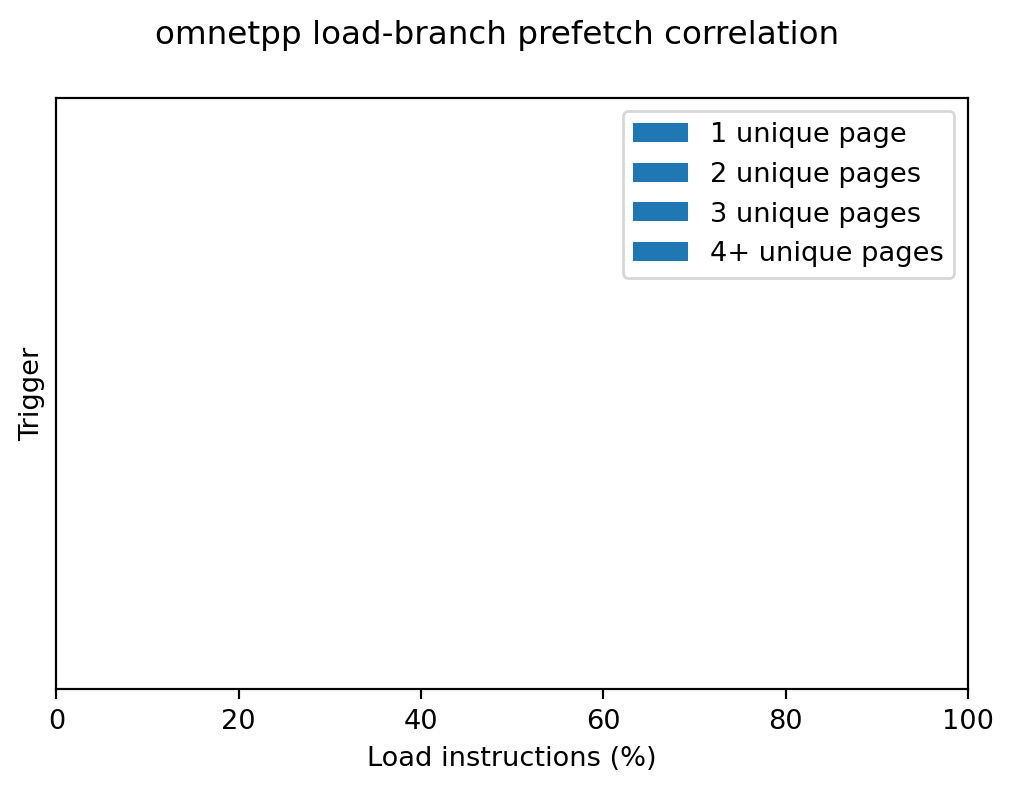

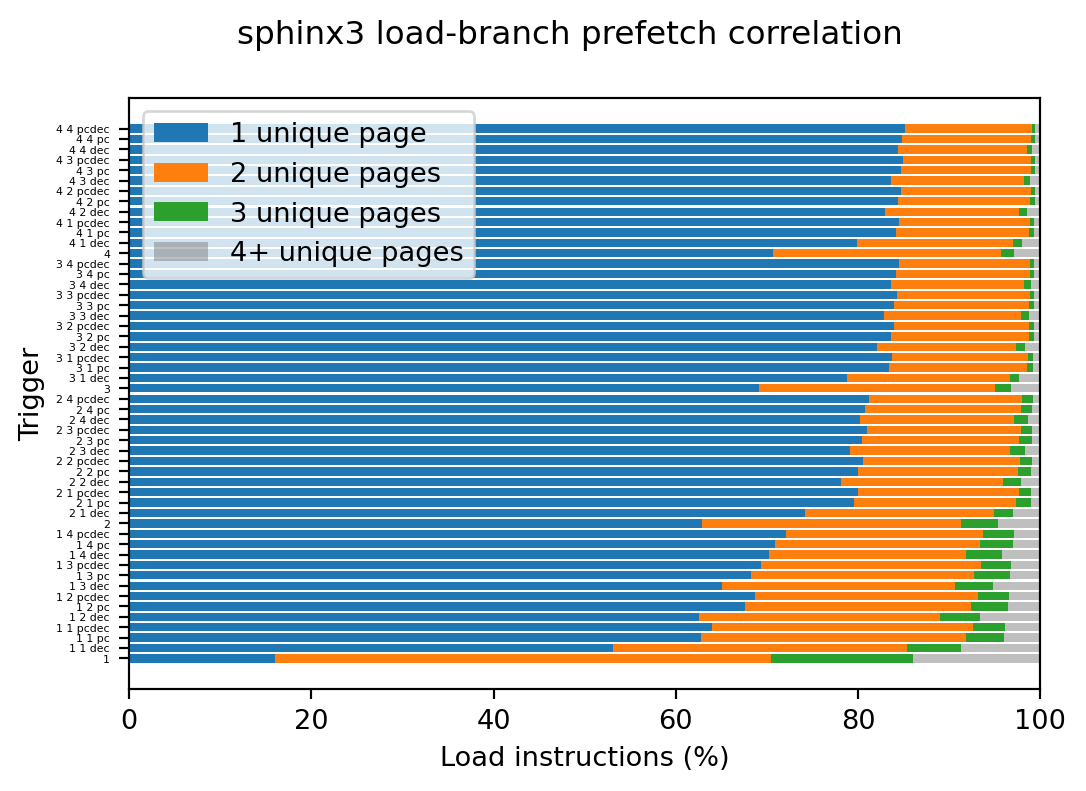

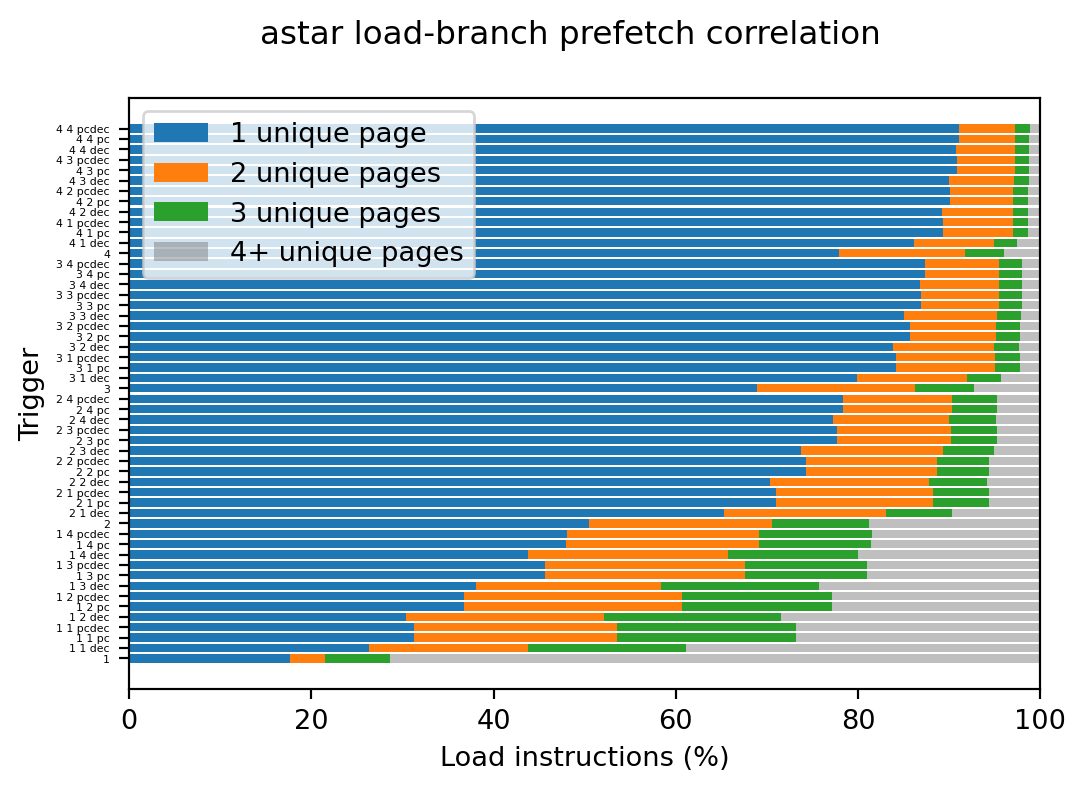

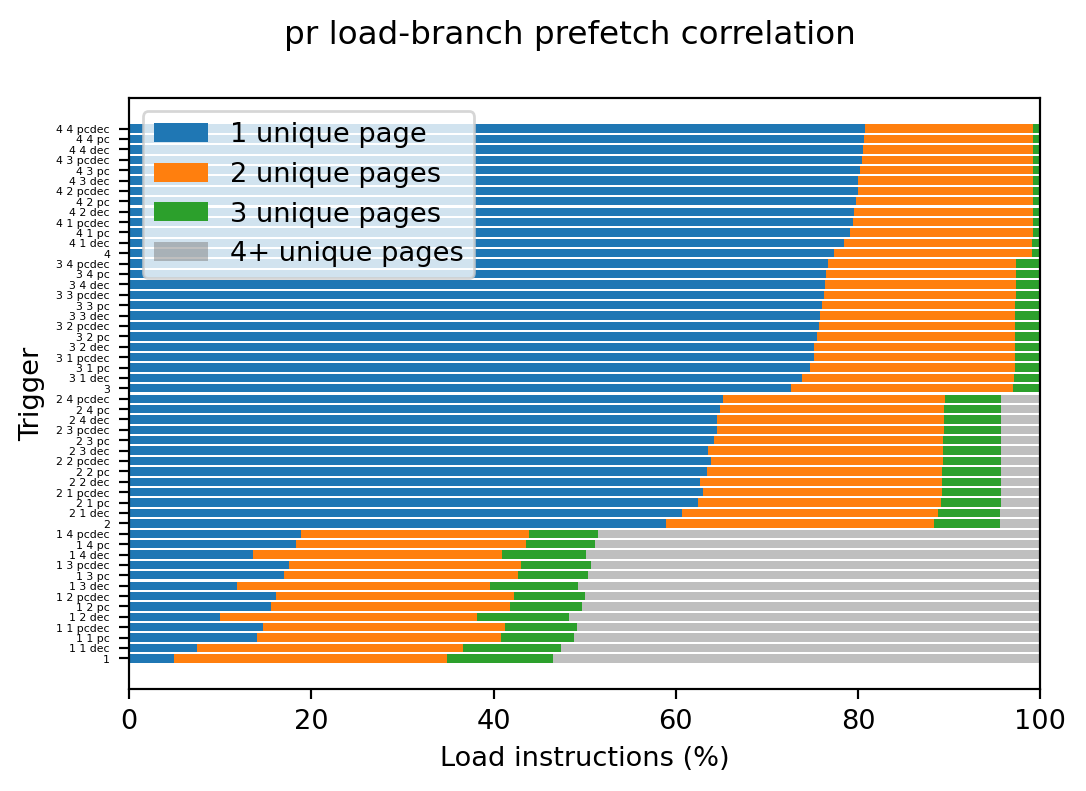

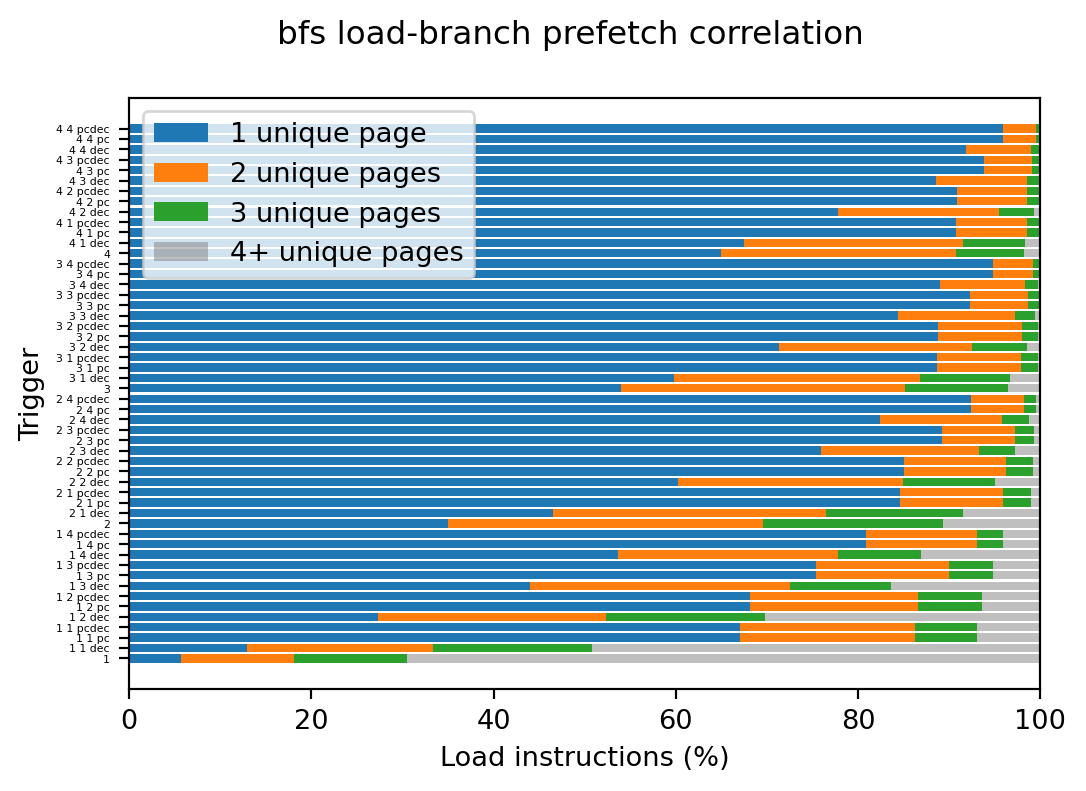

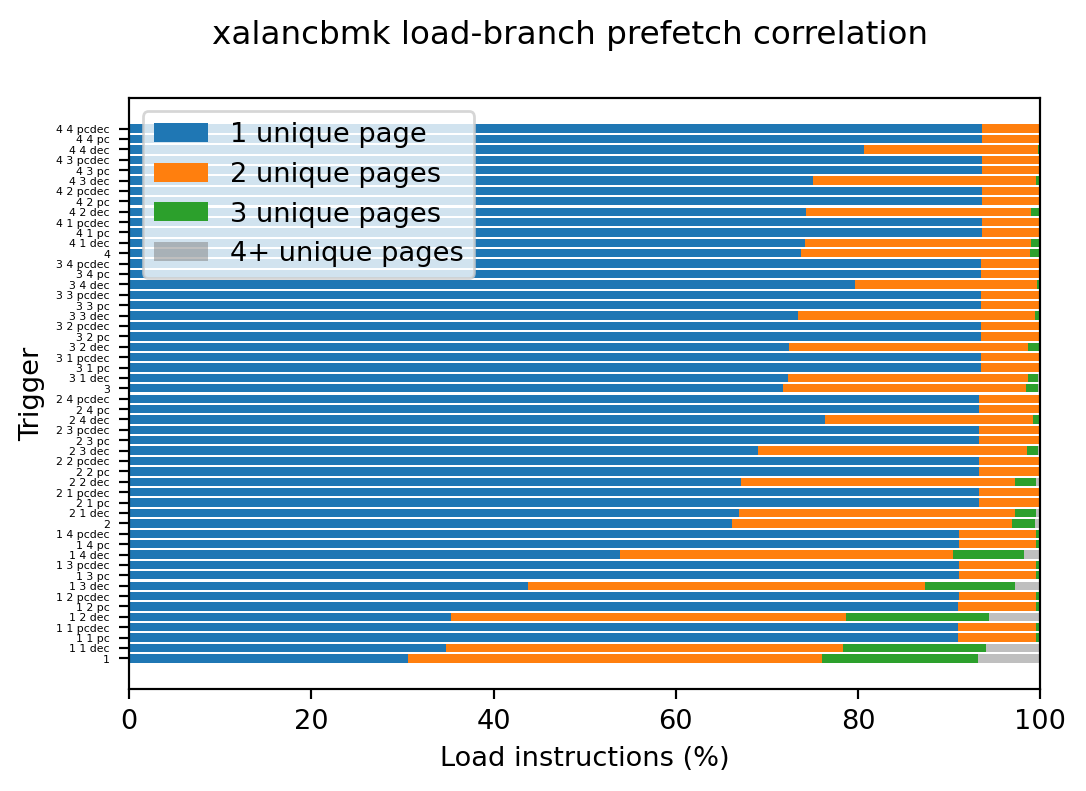

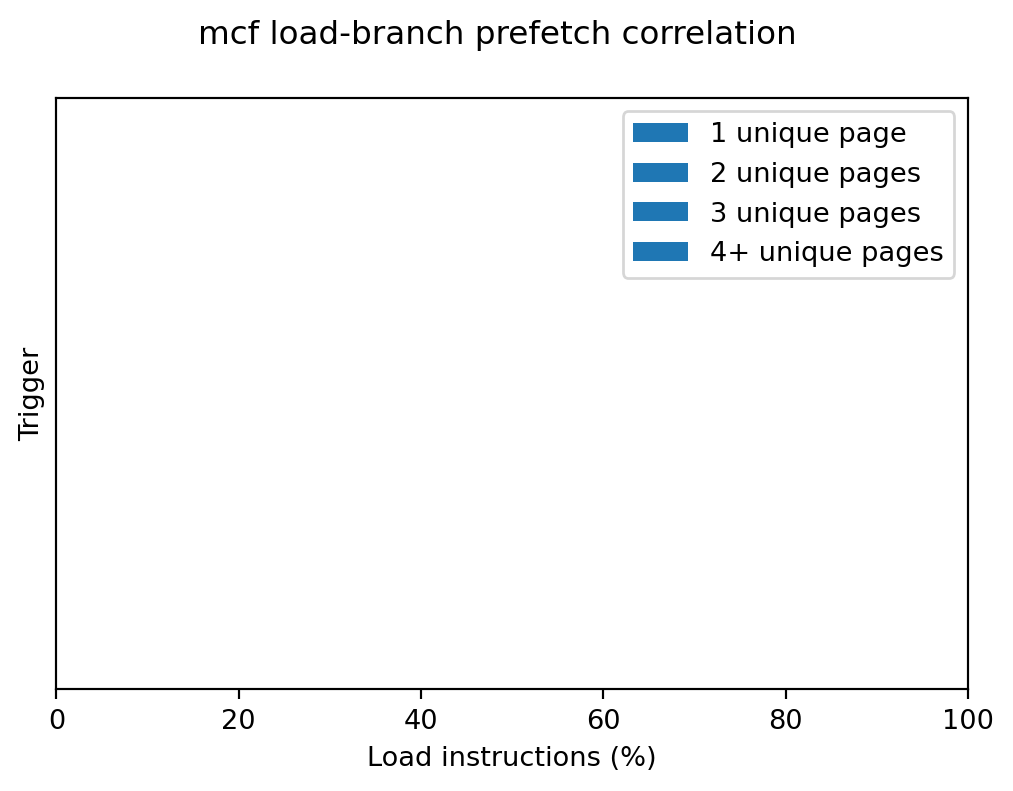

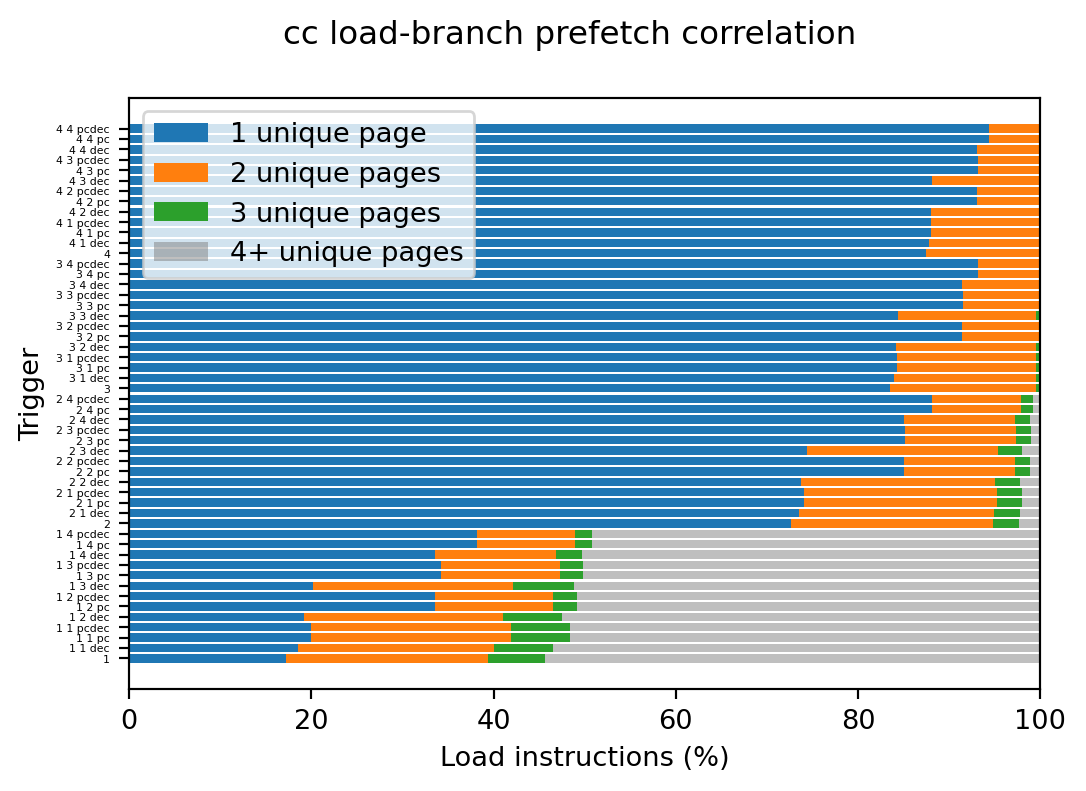

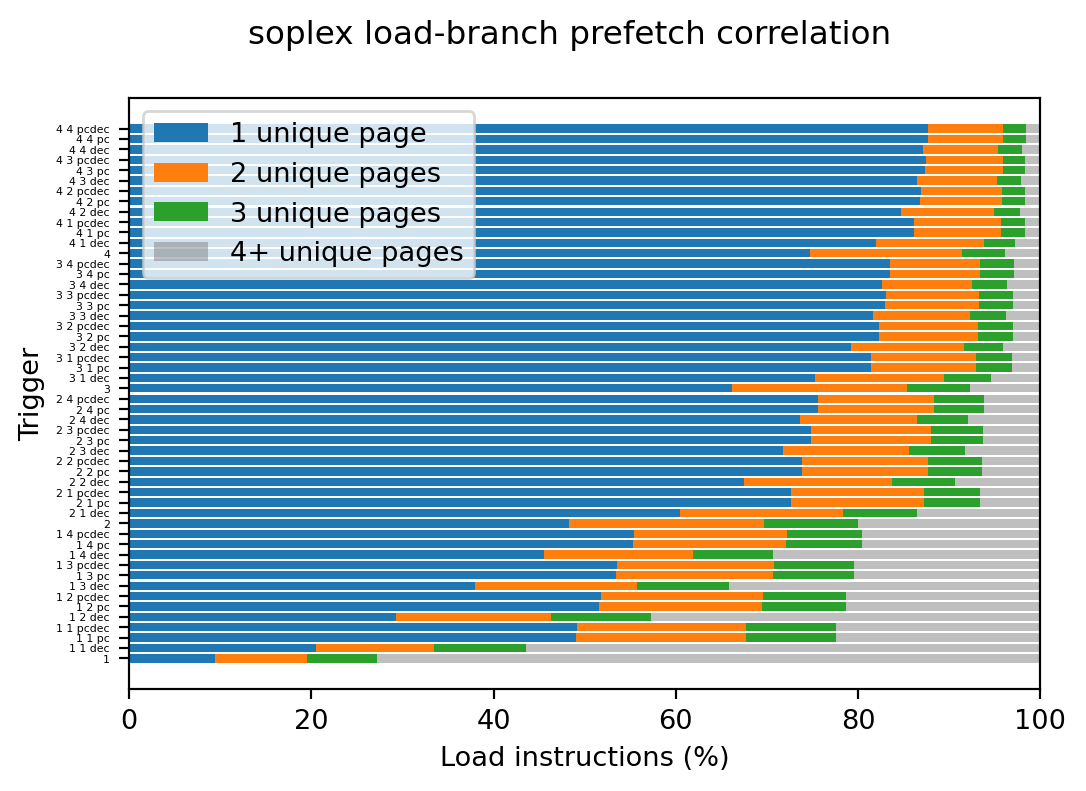

In [162]:
def plot_correlation(trace_results, trace_name=''):
    p1, p2, p3, prest = [], [], [], []
    triggers = []
    for trigger in trace_results.keys():
        # if trigger[2] and 'dec' in trigger[2]:
        #     continue
        # if trigger[2] and trigger[1] != 4:
        #     continue
        
        triggers.append(trigger)
        s = sum(trace_results[trigger].values())
        p1.append(trace_results[trigger][1] / s * 100.)
        p2.append(trace_results[trigger][2] / s * 100.)
        p3.append(trace_results[trigger][3] / s * 100.)
        prest.append(100. - p1[-1] - p2[-1] - p3[-1])
    
    p1, p2, p3, prest = np.array(p1), np.array(p2), np.array(p3), np.array(prest)
    fig, ax = plt.subplots(dpi=196)
   
    ax.barh(range(len(p1)), p1, label='1 unique page')
    ax.barh(range(len(p2)), p2, left=p1, label='2 unique pages')
    ax.barh(range(len(p3)), p3, left=p1 + p2, label='3 unique pages')
    ax.barh(range(len(prest)), prest, left=p1 + p2 + p3, color='gray', alpha=0.5, label='4+ unique pages')
    
    ax.set_yticks(range(len(p1)))
    lab = [f'{l} {b if b else ""} {bt if bt else ""}' for l, b, bt in triggers]
    lab = [l.rstrip() for l in lab]
    ax.set_yticklabels(lab, fontsize=4)
    ax.set_xlim(xmin=0, xmax=100)
    ax.set_ylabel('Trigger')
    ax.set_xlabel('Load instructions (%)')
    ax.legend()
    
    fig.suptitle(f'{trace_name} load-branch prefetch correlation')
    plt.show()
    
for trace, res in results.items():
    plot_correlation(res, trace_name=trace)

